In [16]:
from typing import Literal

import numpy as np
import pandas as pd
import requests
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

## Constants

In [58]:
DECISIVE_METRIC = 'hits_at_10'
DECISIVE_METRIC_OPTIMUM = 'max'

# Number of top k predictions to keep for generating
# new triple patterns
TOP_K = 10

# Set Seaborn theme
SEABORN_THEME = 'darkgrid'
sns.set_theme(style=SEABORN_THEME)

## Load Wikidata5M

In [18]:
SubsetType = Literal['train', 'valid', 'test']


def load_wikidata5m_dataset(subset_type: SubsetType):
    return pd.read_csv(f'dataset/wikidata5m/wikidata5m_transductive_{subset_type}.txt', sep='\t', names=['S', 'P', 'O'])


wikidata5m_train = load_wikidata5m_dataset('train')
wikidata5m_valid = load_wikidata5m_dataset('valid')
wikidata5m_test = load_wikidata5m_dataset('test')

## Load trained models and mappings

In [19]:
def get_trained_models():
    return {
        'complex': torch.load('embeddings/dim_32/complex/trained_model.pkl'),
        'distmult': torch.load('embeddings/dim_32/distmult/trained_model.pkl'),
        'simple': torch.load('embeddings/dim_32/simple/trained_model.pkl'),
        'transe': torch.load('embeddings/dim_32/transe/trained_model.pkl')
    }


def get_trained_entity_mappings():
    return {
        'complex': TriplesFactory.from_path_binary('embeddings/dim_32/complex/training_triples'),
        'distmult': TriplesFactory.from_path_binary('embeddings/dim_32/distmult/training_triples'),
        'simple': TriplesFactory.from_path_binary('embeddings/dim_32/simple/training_triples'),
        'transe': TriplesFactory.from_path_binary('embeddings/dim_32/transe/training_triples')
    }


trained_models = get_trained_models()
entity_mappings = get_trained_entity_mappings()

## Load predicate metrics

In [20]:
dim32_predicate_metrics = pd.read_csv('metrics/predicate_metrics.csv')

# Only consider realistic values, evaluated on both ends
dim32_predicate_metrics = dim32_predicate_metrics.query('Type == "realistic" and Side == "both"')

## Utilities

In [21]:
def get_wikidata_property_labels(property_ids: list) -> dict:
    wikidata_api = 'https://www.wikidata.org/w/api.php'
    params = {
        'action': 'wbgetentities',
        'ids': '|'.join(property_ids),
        'languages': 'en',
        'props': 'labels',
        'format': 'json'
    }

    response = requests.get(wikidata_api, params).json()

    property_labels = []
    for pid in property_ids:
        property_labels.append(response['entities'][pid]['labels']['en']['value'])

    return property_labels


def format_triple(subject, predicate, obj):
    if obj.startswith('?o'):
        return f'{subject} {predicate} {obj}   {get_wikidata_property_labels([subject, predicate])}'

    return f'{subject} {predicate} {obj}   {get_wikidata_property_labels([subject, predicate, obj])}'

## Functions

In [59]:
def find_train_triple_with_predicate(predicate_name):
    triples = wikidata5m_train.query('P == @predicate_name')

    if len(triples) > 0:
        i = np.random.randint(len(triples))
        random_triple = tuple(triples.iloc[i][['S', 'P', 'O']])
        return random_triple
    else:
        print(f'Error: No triples found for predicate {predicate_name} in training set')


def find_train_triple_with_subject(subject_name):
    triples = wikidata5m_train.query('S == @subject_name')

    if len(triples) > 0:
        i = np.random.randint(len(triples))
        random_triple = tuple(triples.iloc[i][['S', 'P', 'O']])
        return random_triple
    else:
        print(f'Error: No triples found for subject {subject_name} in training set')


def select_best_model(predicate_metrics, predicate_name):
    metrics_df = predicate_metrics.query('Metric == @DECISIVE_METRIC and relation_label == @predicate_name')

    optimal_metric = None
    if DECISIVE_METRIC_OPTIMUM == 'min':
        optimal_metric = metrics_df.loc[metrics_df['Value'].idxmin()]
    elif DECISIVE_METRIC_OPTIMUM == 'max':
        optimal_metric = metrics_df.loc[metrics_df['Value'].idxmax()]

    return optimal_metric['model']


def predict_tail(model_name, subject, predicate):
    model = trained_models[model_name]
    triples_factory = entity_mappings[model_name]

    return process_predictions(
        predict_target(
            model=model,
            head=subject,
            relation=predicate,
            tail=None,
            triples_factory=triples_factory
        ), model_name)


def process_predictions(predictions, model_name):
    predictions_df = predictions.df.assign(model=model_name)
    predictions_df = predictions_df.sort_values(by='score', ascending=False, ignore_index=True)
    return predictions_df.head(n=TOP_K)

## Best Model Counts

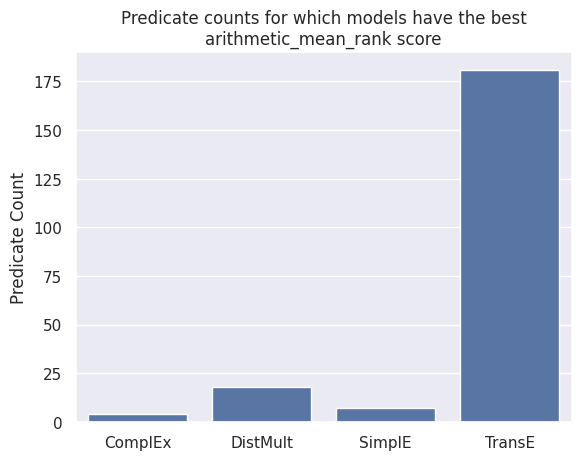

In [89]:
def compute_best_model_counts(predicate_metrics):
    predicate_metrics = predicate_metrics.query('Metric == @DECISIVE_METRIC')

    model_counts = {
        'complex': 0,
        'distmult': 0,
        'simple': 0,
        'transe': 0
    }
    for predicate_name, metrics_df in predicate_metrics.groupby(by='relation_label'):
        best_model = select_best_model(metrics_df, predicate_name)
        model_counts[best_model] += 1

    return pd.Series(model_counts)


def plot_best_model_counts(model_counts, embedding_dim=32):
    sns.set_theme(style=SEABORN_THEME)

    model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']
    if 'complex' not in model_counts.index.values:
        model_labels = ['DistMult', 'SimplE', 'TransE']

    # Plot best model counts
    ax = sns.barplot(data=model_counts)
    ax.set_title(f'Predicate counts for which dim{embedding_dim} models have the best\n{DECISIVE_METRIC} score')
    ax.set_ylabel('Predicate Count')
    ax.set_xticks(np.arange(len(model_labels)))
    ax.set_xticklabels(model_labels)

    plt.show()


best_model_counts = compute_best_model_counts(dim32_predicate_metrics)
plot_best_model_counts(best_model_counts)

# Predictions

## First Triple Prediction

In [65]:
start_predicate = 'P106'  # "occupation"
s1, p1, o1 = find_train_triple_with_predicate(start_predicate)
print(f'Triple Pattern:  {s1} {p1} ?o1')
print('Original triple:', format_triple(s1, p1, o1))

best_model = select_best_model(dim32_predicate_metrics, p1)
print('Best model:', best_model)

Triple Pattern:  Q24059314 P106 ?o1
Original triple: Q24059314 P106 Q628099   ['Connor McLennan', 'occupation', 'association football manager']
Best model: simple


In [66]:
first_predictions = predict_tail(best_model, subject=s1, predicate=p1)
first_predictions.head()

,tail_id,score,tail_label,model
0,4545786,4.730696,Q937857,simple
1,3414869,4.597007,Q628099,simple
2,4067161,4.109388,Q747074,simple
3,333123,3.668683,Q1388231,simple
4,3741101,3.536046,Q6946022,simple


In [67]:
pred_o1 = first_predictions.iloc[0]['tail_label']
print(f'?o1 -> {pred_o1}  {get_wikidata_property_labels([pred_o1])}')
print('Predicted triple:', format_triple(s1, p1, pred_o1))

?o1 -> Q937857  ['association football player']
Predicted triple: Q24059314 P106 Q937857   ['Connor McLennan', 'occupation', 'association football player']


## Second Triple Prediction

In [68]:
s2, p2, o2 = find_train_triple_with_subject(pred_o1)
print(f'Triple Pattern:  {s2} {p2} ?o2')
print('Original triple:', format_triple(s2, p2, o2))

best_model = select_best_model(dim32_predicate_metrics, p2)
print('Best model:', best_model)

Triple Pattern:  Q937857 P31 ?o2
Original triple: Q937857 P31 Q28640   ['association football player', 'instance of', 'profession']
Best model: simple


In [69]:
second_predictions = predict_tail(best_model, subject=s2, predicate=p2)
second_predictions.head()

,tail_id,score,tail_label,model
0,4311478,10.906454,Q7889,simple
1,4047662,9.293348,Q7432,simple
2,1318858,6.898678,Q2198484,simple
3,2359679,6.827145,Q4430012,simple
4,2026615,6.714136,Q33506,simple


In [70]:
pred_o2 = second_predictions.iloc[0]['tail_label']
print(f'?o2 -> {pred_o2}  {get_wikidata_property_labels([pred_o2])}')
print('Predicted triple:', format_triple(s2, p2, pred_o2))

?o2 -> Q7889  ['video game']
Predicted triple: Q937857 P31 Q7889   ['association football player', 'instance of', 'video game']


## Third Triple Prediction

In [72]:
s3, p3, o3 = find_train_triple_with_subject(pred_o2)
print(f'Triple Pattern:  {s3} {p3} ?o3')
print(f'Original triple:', format_triple(s3, p3, o3))

best_model = select_best_model(dim32_predicate_metrics, p3)
print('Best model:', best_model)

Triple Pattern:  Q7889 P279 ?o3
Original triple: Q7889 P279 Q166142   ['video game', 'subclass of', 'application']
Best model: complex


In [73]:
third_predictions = predict_tail(best_model, subject=s3, predicate=p3)
third_predictions.head()

,tail_id,score,tail_label,model
0,1212112,7.652782,Q20737639,complex
1,4548870,6.889242,Q940528,complex
2,3031003,6.748481,Q5444174,complex
3,2652825,6.433424,Q4912365,complex
4,1510797,6.375384,Q24884386,complex


In [74]:
pred_o3 = third_predictions.iloc[0]['tail_label']
print(f'?o3 -> {pred_o3}  {get_wikidata_property_labels([pred_o3])}')
print('Predicted triple:', format_triple(s3, p3, pred_o3))

?o3 -> Q20737639  ['Harold Winberg']
Predicted triple: Q7889 P279 Q20737639   ['video game', 'subclass of', 'Harold Winberg']


## Two-Step Link Prediction using TOP K predictions

In [60]:
def do_object_link_prediction(subj, pred, level):
    formatted_triple = format_triple(subj, pred, "?o" + str(level))
    print(f'Triple Pattern (Level {level}):  {formatted_triple}')
    
    best_model = select_best_model(dim32_predicate_metrics, pred)
    print(f'Best model for {pred}: {best_model}\n')
    
    predictions = predict_tail(best_model, subject=subj, predicate=pred)
    
    labeled_predictions = predictions.assign(wd_label=get_wikidata_property_labels(predictions['tail_label'].values))
    print(f'Top {TOP_K} Predictions for ?o{level}:   {formatted_triple}')
    print(labeled_predictions[['tail_label', 'wd_label', 'model', 'score']], '\n')
    
    return labeled_predictions, best_model

def do_two_step_link_prediction(predicate1, predicate2):
    s1, p1, _ = find_train_triple_with_predicate(predicate1)
    o1_predictions, best_model_o1 = do_object_link_prediction(s1, p1, 1)
    
    two_step_predictions = []
    for rank, (index, o_pred) in enumerate(o1_predictions.iterrows(), start=1):
        print(f'Predicting for Rank {rank}: {o_pred["tail_label"]}\n')
        o2_predictions, best_model_o2 = do_object_link_prediction(o_pred['tail_label'], predicate2, 2)
        
        two_step_predictions.append(pd.DataFrame({
            'o1_label': o_pred['tail_label'],
            'o1_wd_label': o_pred['wd_label'],
            'o1_model': best_model_o1,
            'o2_label': o2_predictions['tail_label'],
            'o2_wd_label': o2_predictions['wd_label'],
            'o2_model': best_model_o2,
            'o1_score': o_pred['score'],
            'o2_score': o2_predictions['score'],
            'combined_rank': rank * np.arange(1, len(o2_predictions) + 1)
        }))
        
    return pd.concat(two_step_predictions).sort_values(by='combined_rank')

In [61]:
# 1st Example predictions
#   Q2414363 P413 ?o1
#   ?o2      P641 ?o2
pred_1 = 'P413'  # "position played on team / speciality"
pred_2 = 'P641'  # "sport"

with pd.option_context('display.expand_frame_repr', False):
    example1_predictions = do_two_step_link_prediction(pred_1, pred_2)

example1_predictions

Triple Pattern (Level 1):  Q360687 P413 ?o1   ['Fernando Santos', 'position played on team / speciality']
Best model for P413: transe
Top 10 Predictions for ?o1:   Q360687 P413 ?o1   ['Fernando Santos', 'position played on team / speciality']
  tail_label                 wd_label   model      score
0    Q193592               midfielder  transe -10.438572
1    Q280658                  forward  transe -10.586307
2    Q528145               linebacker  transe -10.636091
3   Q2304909               defenseman  transe -10.727001
4    Q201330               goalkeeper  transe -10.753001
5   Q7740370  The Horticulture Center  transe -10.783266
6    Q212413              point guard  transe -10.798618
7   Q1317534               goaltender  transe -10.815829
8    Q171401                   futsal  transe -10.822495
9    Q462471            power forward  transe -10.835232 

Predicting for Rank 1: Q193592

Triple Pattern (Level 2):  Q193592 P641 ?o2   ['midfielder', 'sport']
Best model for P641: trans

,o1_label,o1_wd_label,o1_model,o2_label,o2_wd_label,o2_model,o1_score,o2_score,combined_rank
0,Q193592,midfielder,transe,Q193592,midfielder,transe,-10.438572,-8.305082,1
0,Q280658,forward,transe,Q280658,forward,transe,-10.586307,-8.305082,2
1,Q193592,midfielder,transe,Q280658,forward,transe,-10.438572,-8.665577,2
2,Q193592,midfielder,transe,Q278835,Edward,transe,-10.438572,-8.789646,3
0,Q528145,linebacker,transe,Q528145,linebacker,transe,-10.636091,-8.305082,3
...,...,...,...,...,...,...,...,...,...
9,Q1317534,goaltender,transe,Q204632,Gaelic football,transe,-10.815829,-8.677120,80
8,Q171401,futsal,transe,Q278835,Edward,transe,-10.822495,-9.157472,81
9,Q171401,futsal,transe,Q231200,netball,transe,-10.822495,-9.226324,90
8,Q462471,power forward,transe,Q330039,Cape Verde national football team,transe,-10.835232,-8.655159,90


In [63]:
# 2nd Example predictions
#   Q471987 P47  ?o1
#   ?o2     P421 ?o2
pred_1 = 'P47'   # "shares border with"
pred_2 = 'P421'  # "located in time zone"

with pd.option_context('display.expand_frame_repr', False):
    example2_predictions = do_two_step_link_prediction(pred_1, pred_2)

example2_predictions

Triple Pattern (Level 1):  Q51812 P47 ?o1   ['Alberobello', 'shares border with']
Best model for P47: transe
Top 10 Predictions for ?o1:   Q51812 P47 ?o1   ['Alberobello', 'shares border with']
  tail_label                                      wd_label   model     score
0     Q51812                                   Alberobello  transe -0.357723
1   Q2401930                   San Rafael La Independencia  transe -2.792868
2   Q1205591                                        Yugawa  transe -2.897184
3   Q5376936  Energy Independence and Security Act of 2007  transe -2.956004
4     Q91292                                Piancastagnaio  transe -2.959749
5   Q1010019                                       Cumnock  transe -2.972485
6    Q296217                                          Mori  transe -2.997579
7    Q954528                                      Cudworth  transe -3.001194
8   Q2972484                   Cimetière Sainte-Marguerite  transe -3.007226
9   Q3469831                        

,o1_label,o1_wd_label,o1_model,o2_label,o2_wd_label,o2_model,o1_score,o2_score,combined_rank
0,Q51812,Alberobello,transe,Q6574,UTC±00:00,transe,-0.357723,-5.371396,1
0,Q2401930,San Rafael La Independencia,transe,Q2086913,Central Time Zone,transe,-2.792868,-5.540226,2
1,Q51812,Alberobello,transe,Q2204,UTC−08:00,transe,-0.357723,-5.551477,2
2,Q51812,Alberobello,transe,Q5385,UTC−06:00,transe,-0.357723,-5.728927,3
0,Q1205591,Yugawa,transe,Q190252,Eastern European Time,transe,-2.897184,-6.222285,3
...,...,...,...,...,...,...,...,...,...
9,Q954528,Cudworth,transe,Q7805340,time in India,transe,-3.001194,-6.712072,80
8,Q2972484,Cimetière Sainte-Marguerite,transe,Q207020,Central European Summer Time,transe,-3.007226,-5.696478,81
9,Q2972484,Cimetière Sainte-Marguerite,transe,Q2212,UTC−07:00,transe,-3.007226,-5.700778,90
8,Q3469831,Eidapere,transe,Q6655,UTC+01:00,transe,-3.017097,-6.296632,90


In [64]:
# 3rd Example predictions
#   Q27064158 P1344 ?o1
#   ?o2       P641  ?o2
pred_1 = 'P1344'   # "participant in"
pred_2 = 'P641'    # "sport"

with pd.option_context('display.expand_frame_repr', False):
    example3_predictions = do_two_step_link_prediction(pred_1, pred_2)

example3_predictions

Triple Pattern (Level 1):  Q21715916 P1344 ?o1   ['Kristian Johansen', 'participant in']
Best model for P1344: distmult
Top 10 Predictions for ?o1:   Q21715916 P1344 ?o1   ['Kristian Johansen', 'participant in']
  tail_label                     wd_label     model     score
0      Q8567         2008 Summer Olympics  distmult  0.038311
1   Q2484236          Chalkanoras Idaliou  distmult  0.037833
2      Q8531         1996 Summer Olympics  distmult  0.037552
3   Q2697893                    ASIL Lysi  distmult  0.037368
4    Q959341     Enosis Neon Paralimni FC  distmult  0.037356
5    Q131378                   APOEL F.C.  distmult  0.036838
6    Q473248  Cyprus Football Association  distmult  0.036824
7   Q3874673           Iraklis Gerolakkou  distmult  0.036739
8   Q4651318                 AEK Kythreas  distmult  0.036613
9   Q3560290               Orfeas Nicosia  distmult  0.036570 

Predicting for Rank 1: Q8567
Triple Pattern (Level 2):  Q8567 P641 ?o2   ['2008 Summer Olympics', 'sport

,o1_label,o1_wd_label,o1_model,o2_label,o2_wd_label,o2_model,o1_score,o2_score,combined_rank
0,Q8567,2008 Summer Olympics,distmult,Q17165362,long track speed skating,transe,0.038311,-7.275528,1
0,Q2484236,Chalkanoras Idaliou,distmult,Q222052,center,transe,0.037833,-6.205412,2
1,Q8567,2008 Summer Olympics,distmult,Q9668,2002 Winter Olympics,transe,0.038311,-7.518282,2
2,Q8567,2008 Summer Olympics,distmult,Q2736,association football,transe,0.038311,-7.598813,3
0,Q8531,1996 Summer Olympics,distmult,Q17165362,long track speed skating,transe,0.037552,-7.564586,3
...,...,...,...,...,...,...,...,...,...
9,Q3874673,Iraklis Gerolakkou,distmult,Q108429,archery,transe,0.036739,-5.970754,80
8,Q4651318,AEK Kythreas,distmult,Q31920,swimming,transe,0.036613,-5.185285,81
9,Q4651318,AEK Kythreas,distmult,Q7707,water polo,transe,0.036613,-5.230999,90
8,Q3560290,Orfeas Nicosia,distmult,Q5212771,Fleet Town F.C.,transe,0.036570,-5.522221,90
